# Modeling - Part 1

In [159]:
import datetime as dt
print('Notebook last updated: {}'.format(dt.datetime.now().strftime('%d-%B-%Y')))

Notebook last updated: 07-August-2018


In [95]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from IPython.display import Image
from IPython.core.display import HTML 
plt.style.use('ggplot')

print('Python Version:', sys.version)
print('Pandas Version:', pd.__version__)
print('Numpy Version:', np.__version__)
print('Matplotlib Version:', matplotlib.__version__)
print('Seaborn Version:',sns.__version__)

%matplotlib inline

Python Version: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 18:21:58) 
[GCC 7.2.0]
Pandas Version: 0.22.0
Numpy Version: 1.14.2
Matplotlib Version: 2.2.2
Seaborn Version: 0.8.1


## Read in the Data

In [156]:
est_hourly = pd.read_parquet('../data/est_hourly.paruqet')
est_hourly.tail()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
2018-01-01 20:00:00,21089.0,13858.0,2732.0,4426.0,18418.0,1962.0,2866.0,9378.0,NaN,44284.0,8401.0,NaN
2018-01-01 21:00:00,20999.0,13758.0,2724.0,4419.0,18567.0,1940.0,2846.0,9255.0,NaN,43751.0,8373.0,NaN
2018-01-01 22:00:00,20820.0,13627.0,2664.0,4355.0,18307.0,1891.0,2883.0,9044.0,NaN,42402.0,8238.0,NaN
2018-01-01 23:00:00,20415.0,13336.0,2614.0,4224.0,17814.0,1820.0,2880.0,8676.0,NaN,40164.0,7958.0,NaN
2018-01-02 00:00:00,19993.0,12816.0,2552.0,4100.0,17428.0,1721.0,2846.0,8393.0,NaN,38608.0,7691.0,NaN


## Train-Test Split

With time series data it is really important that our training set does not contain any data after our split date. We will create a train test split function to handle this.

In [101]:
def split_data(df, frac_train=0.9):
    """
    Splits the dataframe with a time series index.
    `frac_train` determines the percentage of the available data that will be used for training.
    The remaining data will be used for validation.
    """
    max_date = df.index.max()
    min_date = df.index.min()
    days = max_date - min_date
    split_date = pd.to_datetime((min_date + (days * frac_train)).date())
    train = df.loc[df.index <= split_date]
    test = df.loc[df.index > split_date]
    return train, test

In [112]:
train, test = split_data(est_hourly.dropna(subset=['PJME']))
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (130823, 12)
Test shape: (14543, 12)


## Create Time Series Features

In [117]:
def create_features(df, target_col):
    """
    Create timeseries features
    """
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df['hour'] = df.index.hour
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    
    X = df[['month', 'day_of_year', 'hour', 'quarter', 'year']]
    y = df[[target_col]]
    return X, y

### Create Features (X) and Target (y)

In [118]:
# Pull Only important features
X_train, y_train = create_features(train, target_col='PJME')
X_test, y_test = create_features(test, target_col='PJME')

# Baseline Models

In [148]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

reg = LinearRegression()
reg.fit(X_train, y_train)
print('coef {}'.format(reg.coef_))

# Train Accuracy
print('Train R2: {:.3f}'.format(reg.score(X_train, y_train)))
print('Test R2: {:.3f}'.format(reg.score(X_test, y_test)))

test['Linear_Regression_Prediction'] = reg.predict(X_test)

coef [[-193.53441249    5.82796758  459.68450407 -277.40784006  -63.44774856]]
Train R2: 0.245
Test R2: 0.193


In [149]:
from sklearn.linear_model import ElasticNet

reg = ElasticNet()
reg.fit(X_train, y_train)
print('coef {}'.format(reg.coef_))

# Train Accuracy
print('Train R2: {:.3f}'.format(reg.score(X_train, y_train)))
print('Test R2: {:.3f}'.format(reg.score(X_test, y_test)))

test['ElasticNet_Prediction'] = reg.predict(X_test)

coef [-37.79886213  -1.65248211 454.9253641  -43.42370655 -61.78962884]
Train R2: 0.244
Test R2: 0.195


In [150]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg.fit(X_train, y_train)
# Train Accuracy
print('Train R2: {:.3f}'.format(reg.score(X_train, y_train)))
print('Test R2: {:.3f}'.format(reg.score(X_test, y_test)))

test['Random_Forest_Prediction'] = reg.predict(X_test)

/home/robmulla/miniconda3/envs/pjm/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Train R2: 0.989
Test R2: 0.127


/home/robmulla/miniconda3/envs/pjm/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


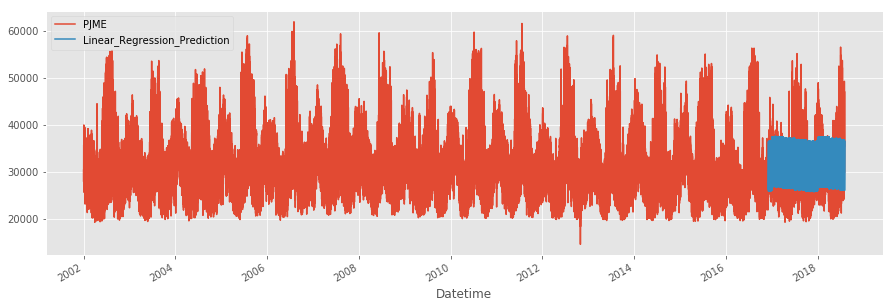

In [151]:
pd.concat([test, train]).plot(y=['PJME', 'Linear_Regression_Prediction'], figsize=(15,5))

/home/robmulla/miniconda3/envs/pjm/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


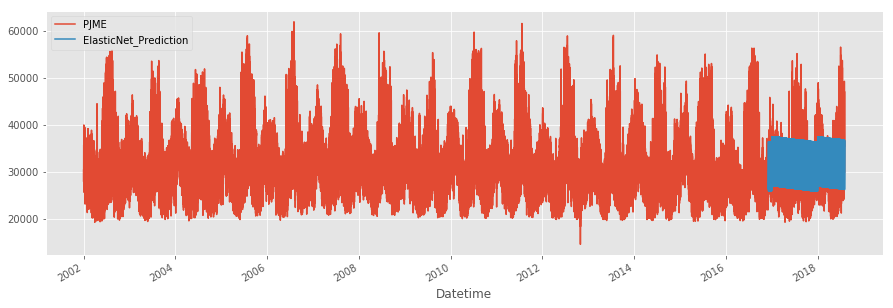

In [152]:
pd.concat([test, train]).plot(y=['PJME', 'ElasticNet_Prediction'], figsize=(15,5))

/home/robmulla/miniconda3/envs/pjm/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


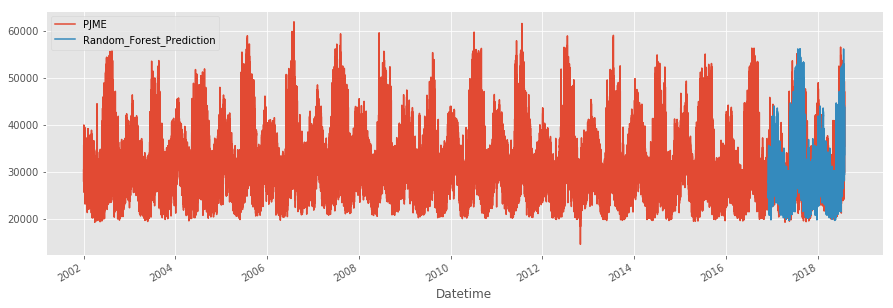

In [155]:
pd.concat([test, train]).plot(y=['PJME', 'Random_Forest_Prediction'], figsize=(15,5))

# More to come....